# Introduksjon

I denne notebooken skal vi ta en veldig kort titt på [RDKit](https://github.com/rdkit/rdkit), programvare for å (blant annet) manipulere på molekyler og generere _features_ fra disse, og [ChEMBL](https://www.ebi.ac.uk/chembl/), en database av _drug-like_ kjemiske forbindelser.

Se tilhørende ELMED219-modul for mer informasjon og motivasjon: https://mitt.uib.no/courses/21357/pages/lab-3-drug-discovery-og-ml. 

Hensikten med å introdusere RDKit er å avmystifisere hands-on-eksempelet [ELMED219-Lab3-Drug_discovery-Merck](). 

> Notebooken er basert på en kombinasjon av RDKit og [`chembl_webresource_client`](https://github.com/chembl/chembl_webresource_client). Vi går ikke i detalj; se dokumentasjonen til RDKit og ChEMBL for mer informasjon. Notebooken er dels basert på https://github.com/rdkit/rdkit-tutorials/tree/master/notebooks og https://github.com/chembl/chembl_webresource_client.

# Setup

Hvis du vil kjøre denne koden må du kjøre følgende kommandoer inne i ELMED219-repositoriet (for å installere RDKit og andre nødvendige biblioteker):

```
cd ELMED219-2020
conda env update --file rdkit-environment.yml
conda activate rdkit
python -m ipykernel install --user --name rdkit --display-name "rdkit"
conda deactivate
jupyter notebook
```

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

Nødvendige funksjoner fra RDKit:

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem

# Last inn fra ChEMBL

Vi trenger noen interessante kjemiske forbindelser å arbeide med. ChEMBL inneholder mange:

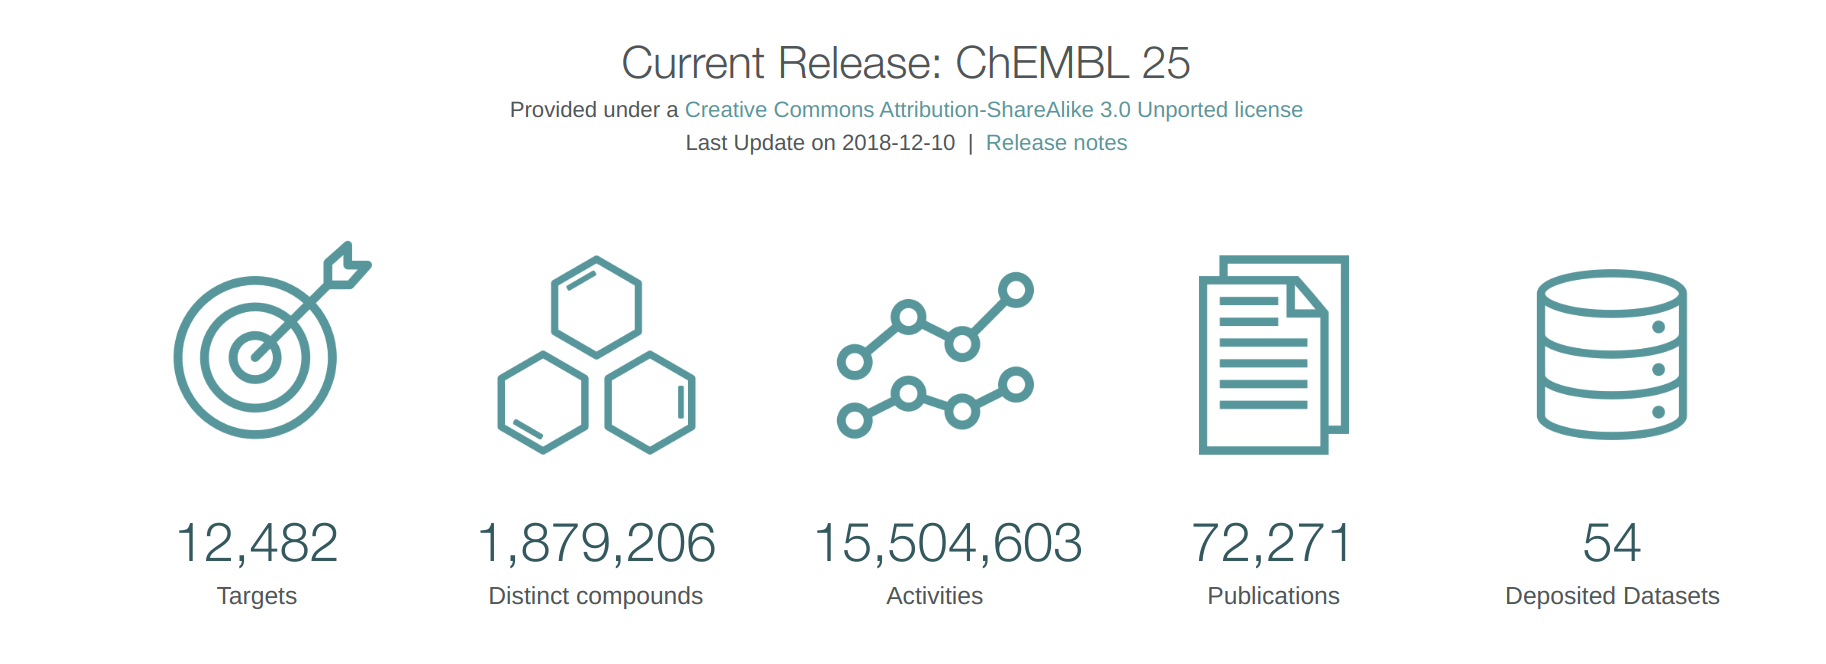

In [1]:
import IPython
IPython.display.Image("./assets/chembl.png", width="100%")

## Eksempel: Hent alle legemidler for lungekreft som er godkjent eller i klinisk utprøving:

Vi behøver en "klient" for å hente data fra ChEMBL-databasen:

In [ ]:
from chembl_webresource_client.new_client import new_client

Vi ønsker å plukke opp molekyler med en viss "drug indication" (lungekreft). Her er alle indikasjoner:

In [ ]:
drug_indication = new_client.drug_indication

In [ ]:
len(drug_indication)

> **Din tur!** Hvis du har lyst til å studere en annen target kan du sjekke noe av det som er tilgjengelig med `for di in drug_indication[:30]:  print(di['efo_term'])`

La oss hente inn alle molekyler fra ChEMBL:

In [ ]:
molecules = new_client.molecule

In [ ]:
len(molecules)

..og filtrere ut alle som har indikasjoner for lungekreft-medisin:

In [ ]:
target = "LUNG CARCINOMA"

In [ ]:
lung_cancer_ind = drug_indication.filter(efo_term__icontains=target)

# Last inn detaljer om alle disse fra ChEMBL:
lung_cancer_mols = molecules.filter(
    molecule_chembl_id__in=[x['molecule_chembl_id'] for x in lung_cancer_ind])

In [ ]:
len(lung_cancer_ind)

Her er et av de potensielle legemidlene med slik indikasjon:

In [ ]:
lung_cancer_ind[1]

Her er alle detaljer fra ChEMBL om dette:

In [ ]:
mol = lung_cancer_mols[1]
mol

## Søk etter lignende molekyler:

Vi kan forsøke å søke etter molekyler som ligner på et av disse. Dette kalles _similaritetssøk_. Se https://onlinelibrary.wiley.com/doi/pdf/10.1002/wcms.23 eller https://en.wikipedia.org/wiki/Chemical_similarity for mer om dette, hvis nysgjerrig.

Strukturen kan beskrives ved såkalte SMILES-strenger (mer om dette her: https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)

In [ ]:
mol_smile = mol['molecule_structures']['canonical_smiles']
mol_smile

Vi kan plotte molekylet:

In [ ]:
mol = AllChem.AddHs(Chem.MolFromSmiles(mol_smile)) #AddHs for å få med hydrogenatomene som ellers vil være implisitte

In [ ]:
mol

Hvor mange atomer?

In [ ]:
mol.GetNumAtoms()

Her søker vi etter lignende molekyler:

In [ ]:
from chembl_webresource_client.new_client import new_client
similarity = new_client.similarity
res = similarity.filter(smiles=mol_smile, similarity=85)

Vi fant følgende antall:

In [ ]:
len(res)

Her er ett:

In [ ]:
res[24]

In [ ]:
similar_mol = AllChem.AddHs(Chem.MolFromSmiles(res[5]['molecule_structures']['canonical_smiles']))
similar_mol

In [ ]:
similar_mol.GetNumAtoms()

# Generer features (fingerprints) fra molekyl

La oss velge noen av molekylene ovenfor og lagre de i en Pandas dataframe:

In [ ]:
from rdkit.Chem import PandasTools

In [ ]:
mols = lung_cancer_mols[:15]

In [ ]:
smiles = [m['molecule_structures']['canonical_smiles'] for m in mols]
names = [m['molecule_synonyms'][0]['molecule_synonym'] for m in mols]

In [ ]:
df = pd.DataFrame(data=zip(smiles,names), columns=['smiles', 'name'])

In [ ]:
df

**Fingerprints** er en måte å representere strukturen til molekyler. Typisk er det en rekke binære True-False (bits) som indikerer hvorvidt gitte strukturer er til stede eller ikke. Her bruker vi såkalte [Morgan fingerprints](http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints).

In [ ]:
mol_fps = [np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 
                                                          useChirality=True, radius=2, 
                                                          nBits = 124)) for s in df.smiles]

In [ ]:
df['fingerprint (MFP2)'] = mol_fps

Nå har vi en tabell av SMILES-representasjon, navn og fingerprint. Nå kunne vi f.eks. forsøkt å søke etter lignende kjemiske forbindelser ved å bruke fingerprintet, eller hentet ut undergrupper som ligner på hverandre. 

In [ ]:
df

# Finn aktivitet mot gitt molekyl

For en god del molekylpar i ChEMBL kan vi finne hvor _aktivt_ det ene virker på det andre. Dette er analogt med oppgaven i Lab 3, men der skal dere lage en modell som predikerer aktivitet fra et fingerprint.

In [ ]:
molecule = new_client.molecule
activities = new_client.activity

Vi ønsker å finne hvor aktivt et gitt molekyl er (Aspirin, Acetylsalisylsyre, ID CHEMBL25) mot et gitt target (Cyclooxygenase, CHEMBL2094253):

In [ ]:
activity = activities.filter(molecule_chembl_id="CHEMBL25", target_chembl_id="CHEMBL2094253",
                  pchembl_value__isnull=False)

In [ ]:
activity

In [ ]:
print(f"Binding efficiency index: {activity[0]['ligand_efficiency']['bei']}\n Surface efficiency index: {activity[0]['ligand_efficiency']['sei']}")

Se her for en beskrivelse av andre molekyler som virker på samme target. Kjenner du igjen noen? 
https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2094253/

In [ ]:
IPython.display.Image("./assets/target_report_card.png", width="100%")

Det er også interessant å se etter predikerte "off-target"-effekter (i.e. kilder til bivirkninger og lignende) til Acetylsalisylsyre:

https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL25

In [ ]:
IPython.display.Image("./assets/report_card_aspirin.png", width="100%")